# Final Project - Identifying Fault Lines from CA Earthquake Patterns

### Sierra Dean, 3033700297

In [4]:
import obspy as op
import numpy as np
import cartopy.crs as ccrs
from obspy.clients.fdsn import Client
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import datetime

### Download, parse, and plot all Earthquakes with magnitude 4 or greater from 1970 to today

In [3]:
currentDT = datetime.datetime.now()
print ('Download initiated.')
print ('Download began: ',str(currentDT))

client = Client("IRIS")
t1 = op.UTCDateTime("1970-01-01T00:00:00") #start time of the request
t2 = op.UTCDateTime("2021-10-27T00:00:00") #end time of the request
minMag = 4
# read https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_events.html
catalog = client.get_events(starttime=t1, endtime=t2, minmagnitude=minMag)

currentDT = datetime.datetime.now()
print ('Download ended: ',str(currentDT))

Download initiated.
Download began:  2021-11-29 14:48:57.432593
Download ended:  2021-11-29 15:59:17.130822


In [6]:
# copy latitude, longitude, depth, and magnitude out of the catalog that they can be plotted below
evlat =[]
evlon =[]
evdep =[]
evmag = []
index = 0

for eve in catalog:
    event = catalog[index]
    org = event.origins
    evlat.append(org[0].latitude)
    evlon.append(org[0].longitude)
    #print(org[0].depth)
    if (org[0].depth==None):
        evdep.append(0.0)
    else:
        evdep.append((org[0].depth) / 1000.0)
    evmag.append((event.magnitudes[0].mag)**4/2)
    index+=1

All earthquakes with magnitude 4+ from 1970 - today.


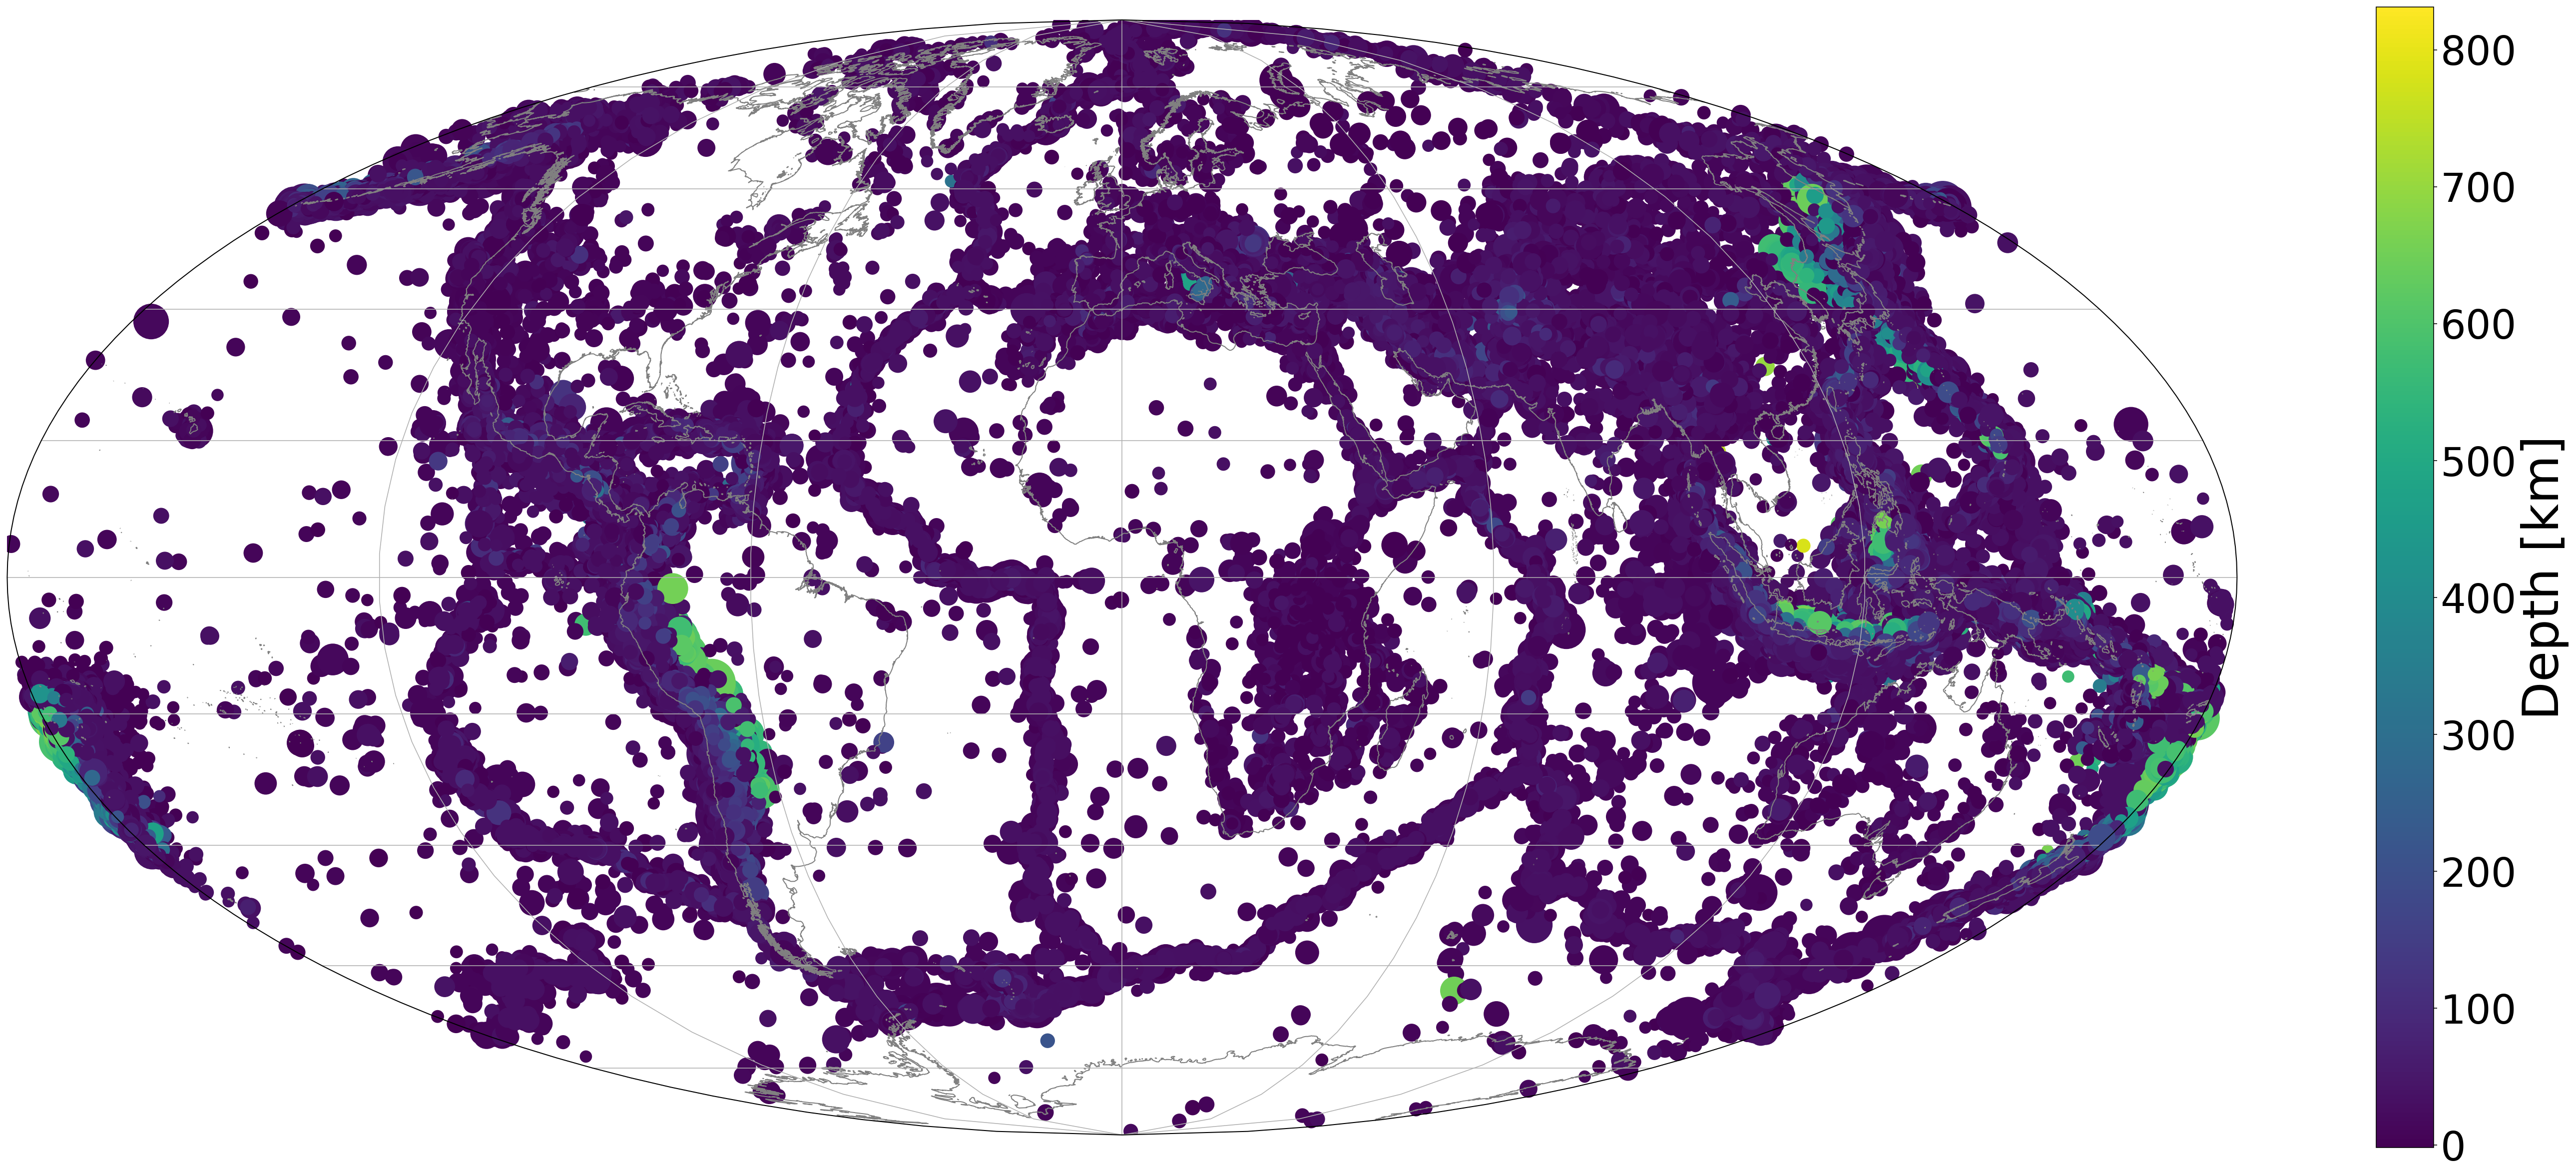

In [7]:
#plt.rcParams['figure.figsize'] = [15, 7]
fig = plt.figure(figsize=(50,30))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude = 0))

events = ax.scatter(evlon, evlat, c=evdep, s=evmag, transform=ccrs.PlateCarree())
    
#Add coastlines and gridlines for lat/lon
ax.coastlines(resolution='10m', color='gray')
ax.gridlines()

cbar = plt.colorbar(events, shrink=0.7)
cbar.set_label('Depth [km]', fontsize=50)
cbar.ax.tick_params(labelsize=40)

print('All earthquakes with magnitude 4+ from 1970 - Today.')
plt.show()

## Goal 1: Locate the San Andreas fault line through analyzing earthquakes in California

In [182]:
## gps extremes for california border

## all cali
ca_s = 32.5
ca_e = -114.1333
ca_n = 42
ca_w = -124

## top half
ca_s_t = 39
ca_e_t = -120
ca_n_t = 42
ca_w_t = -124

## bottom half
ca_s_b = 32.5
ca_e_b = -114.1333
ca_n_b = 39
ca_w_b = -124

In [183]:
## find the boundary line for the slanted part of CA
m = ((ca_n_b - ca_s_b) / (ca_w_b - ca_e_b))
x = ca_e_b
y = ca_s_b
b = y - (m*x)
bottom_half_line = lambda x: (x*m) + b

In [184]:
## locate all earthquakes from those downloaded within this region
cali_eq = []
for i in range(0,len(catalog)):
    lat           = catalog[i].origins[0].latitude
    long          = catalog[i].origins[0].longitude
    if ca_s_t <= lat <= ca_n_t and ca_w_t <= long <= ca_e_t:
        cali_eq.append(catalog[i])
    elif ca_w_b <= long <= ca_e_b and ca_s_b <= lat <= bottom_half_line(long):
        cali_eq.append(catalog[i])

In [185]:
# copy latitude, longitude, depth, and magnitude out of the catalog that they can be plotted below
calat =[]
calon =[]
cadep =[]
camag = []
index = 0

for eve in cali_eq:
    event = cali_eq[index]
    org = event.origins
    calat.append(org[0].latitude)
    calon.append(org[0].longitude)
    if (org[0].depth==None):
        cadep.append(0.0)
    else:
        cadep.append((org[0].depth) / 1000.0)
    camag.append((event.magnitudes[0].mag)**4/2)
    index+=1

California Earthquakes from 1970 to Present


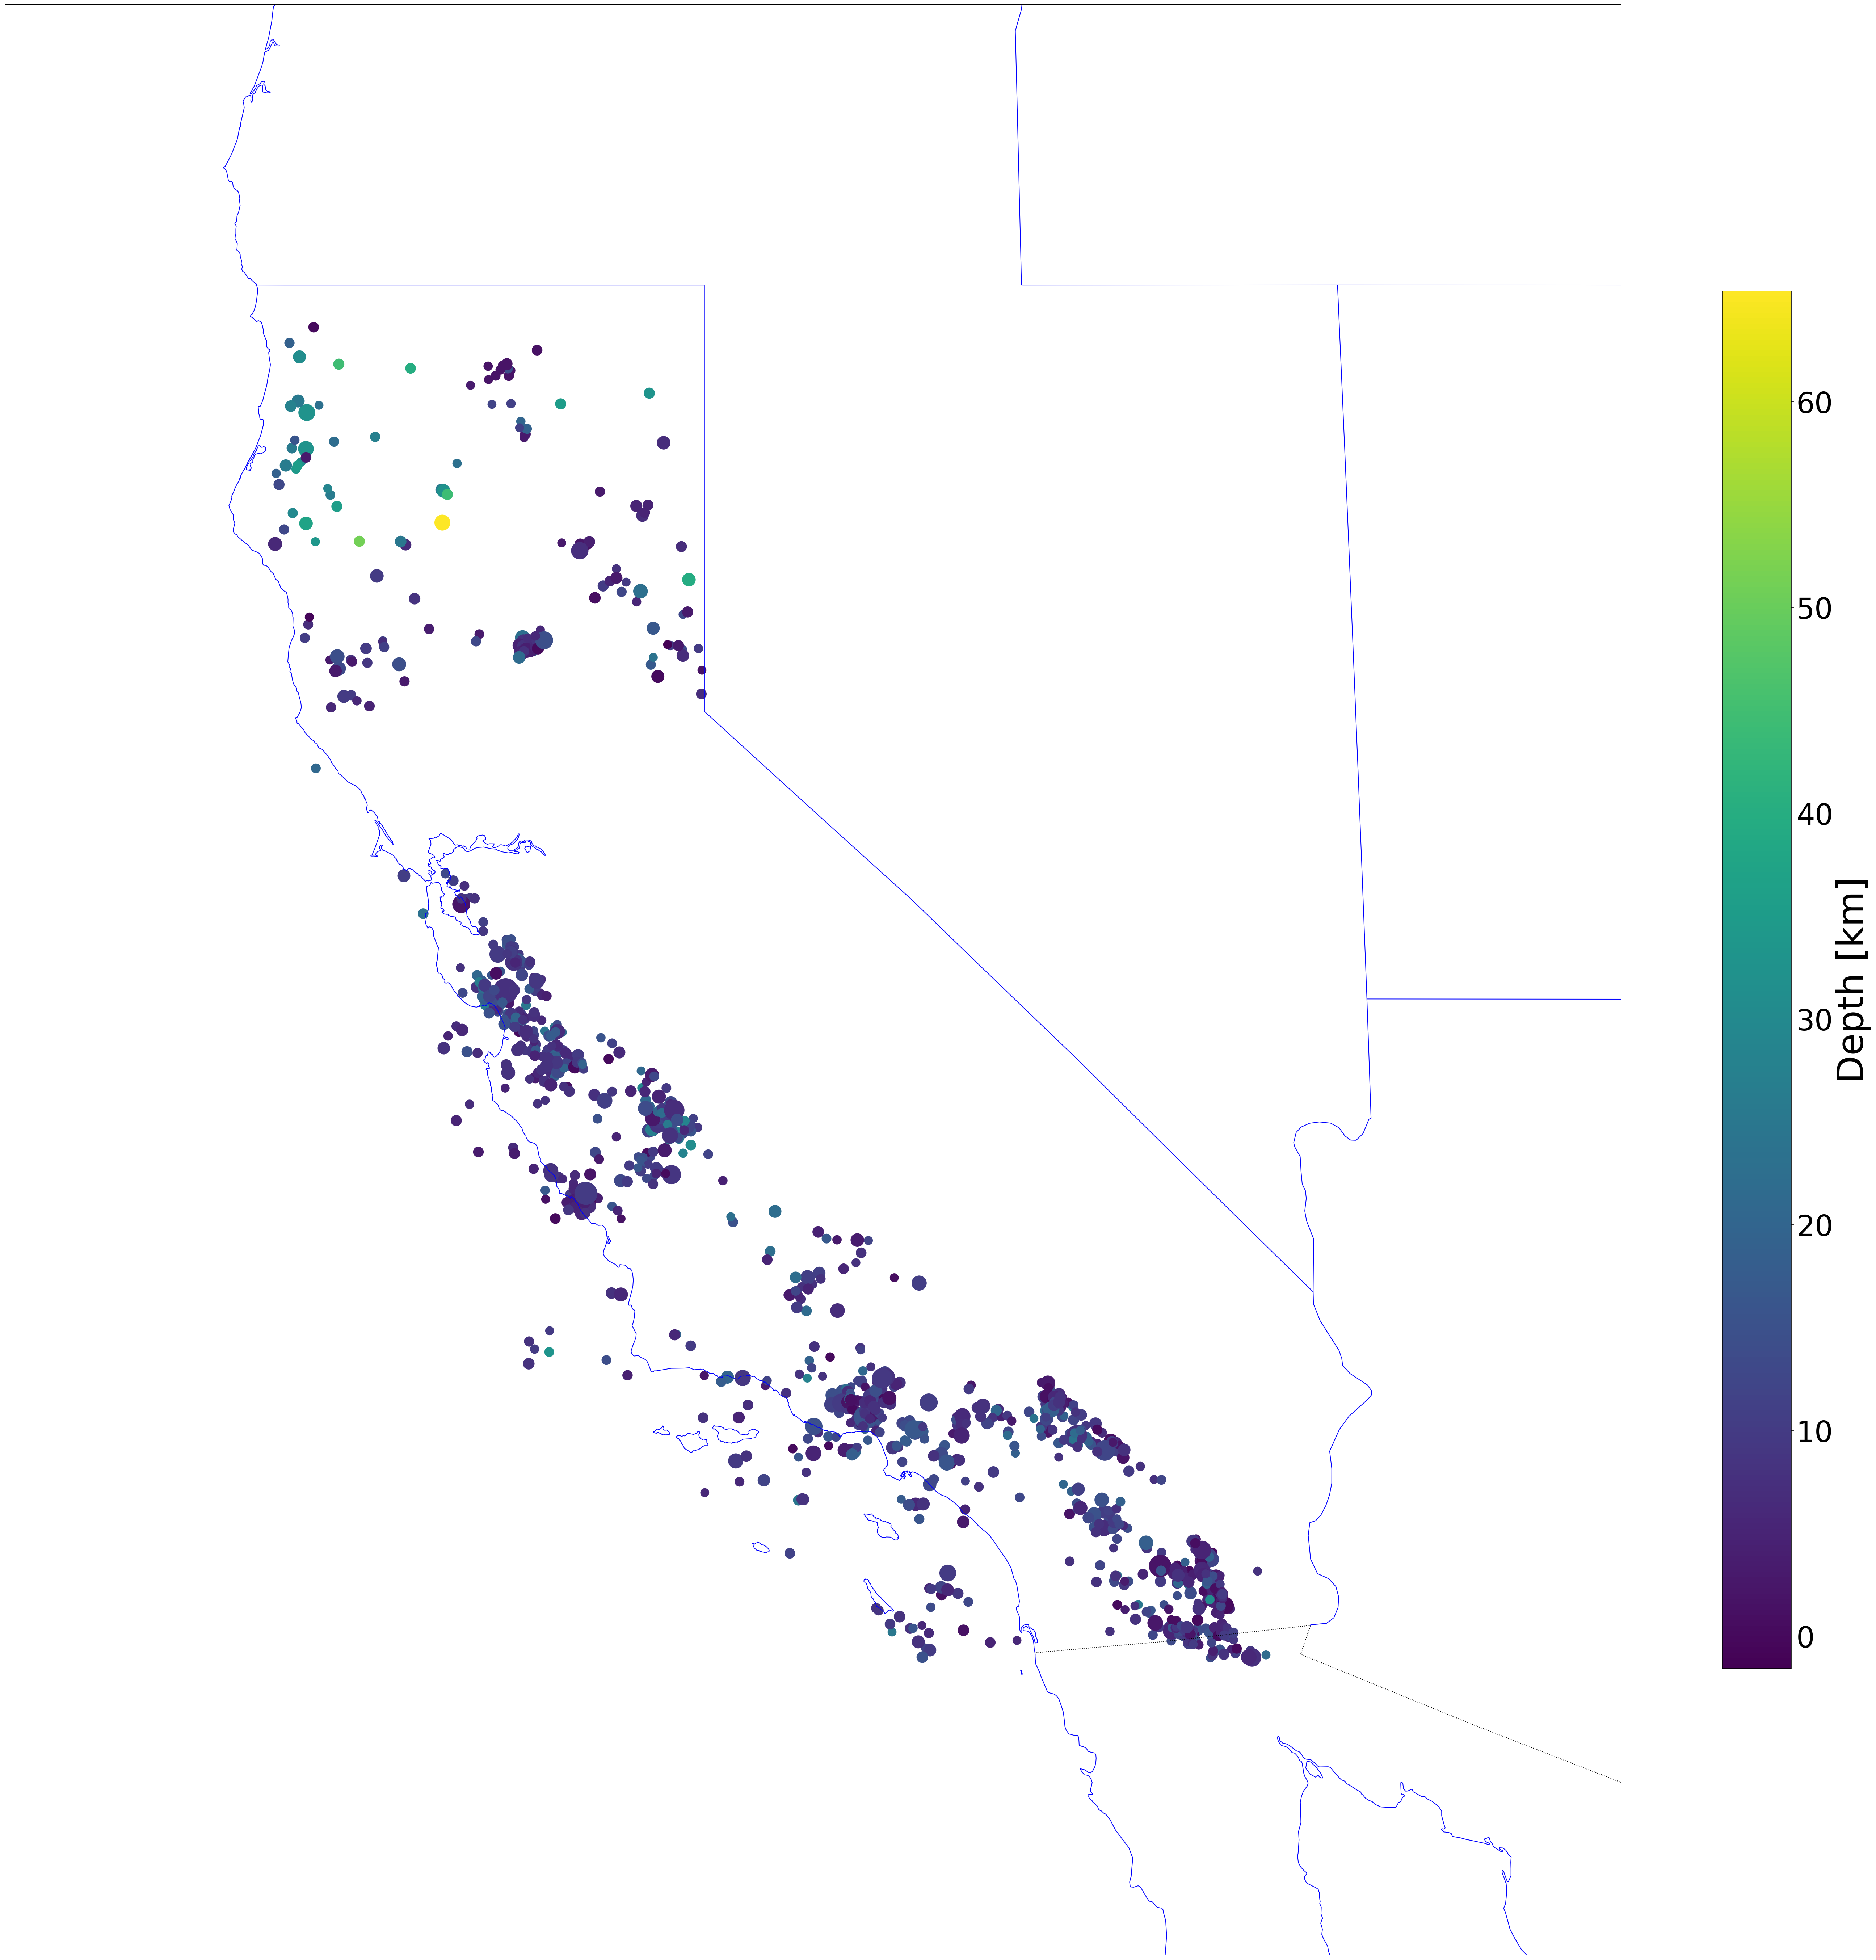

In [186]:
fig = plt.figure(figsize=(50,50))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude = -120))

# Plot all california earthquakes
events = ax.scatter(calon, calat, c=cadep, s=camag, transform=ccrs.PlateCarree())

# center map over california showing whole state
ax.set_extent([ca_w-2, ca_e+2, ca_s-2, ca_n+2], crs=ccrs.Geodetic())

# add state borders, coastlines, and country borders for visualization aid
ax.add_feature(cfeature.BORDERS, linestyle=':')

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='blue')
ax.plot(calon, bottom_half_line(np.array(calon)), color="red")
ax.coastlines(resolution='10m', color='blue')
#ax.gridlines()
cbar = plt.colorbar(events, shrink=0.7)
cbar.set_label('Depth [km]', fontsize=50)
cbar.ax.tick_params(labelsize=40)

print('California Earthquakes from 1970 to Present')
plt.show()

In [187]:
## Notes:
## from this map we can see a clear fault lines: one extending up along the coast
## now we will calculate the actual line and draw it on the map

In [188]:
## calculate line of best fit for fault line
a, b, c = np.polyfit(calon, calat, 2) ## choosing two as the 2-nd degree polynomial will fit better

Earthquakes plus line of best fit inidicating prospective plate boundary.


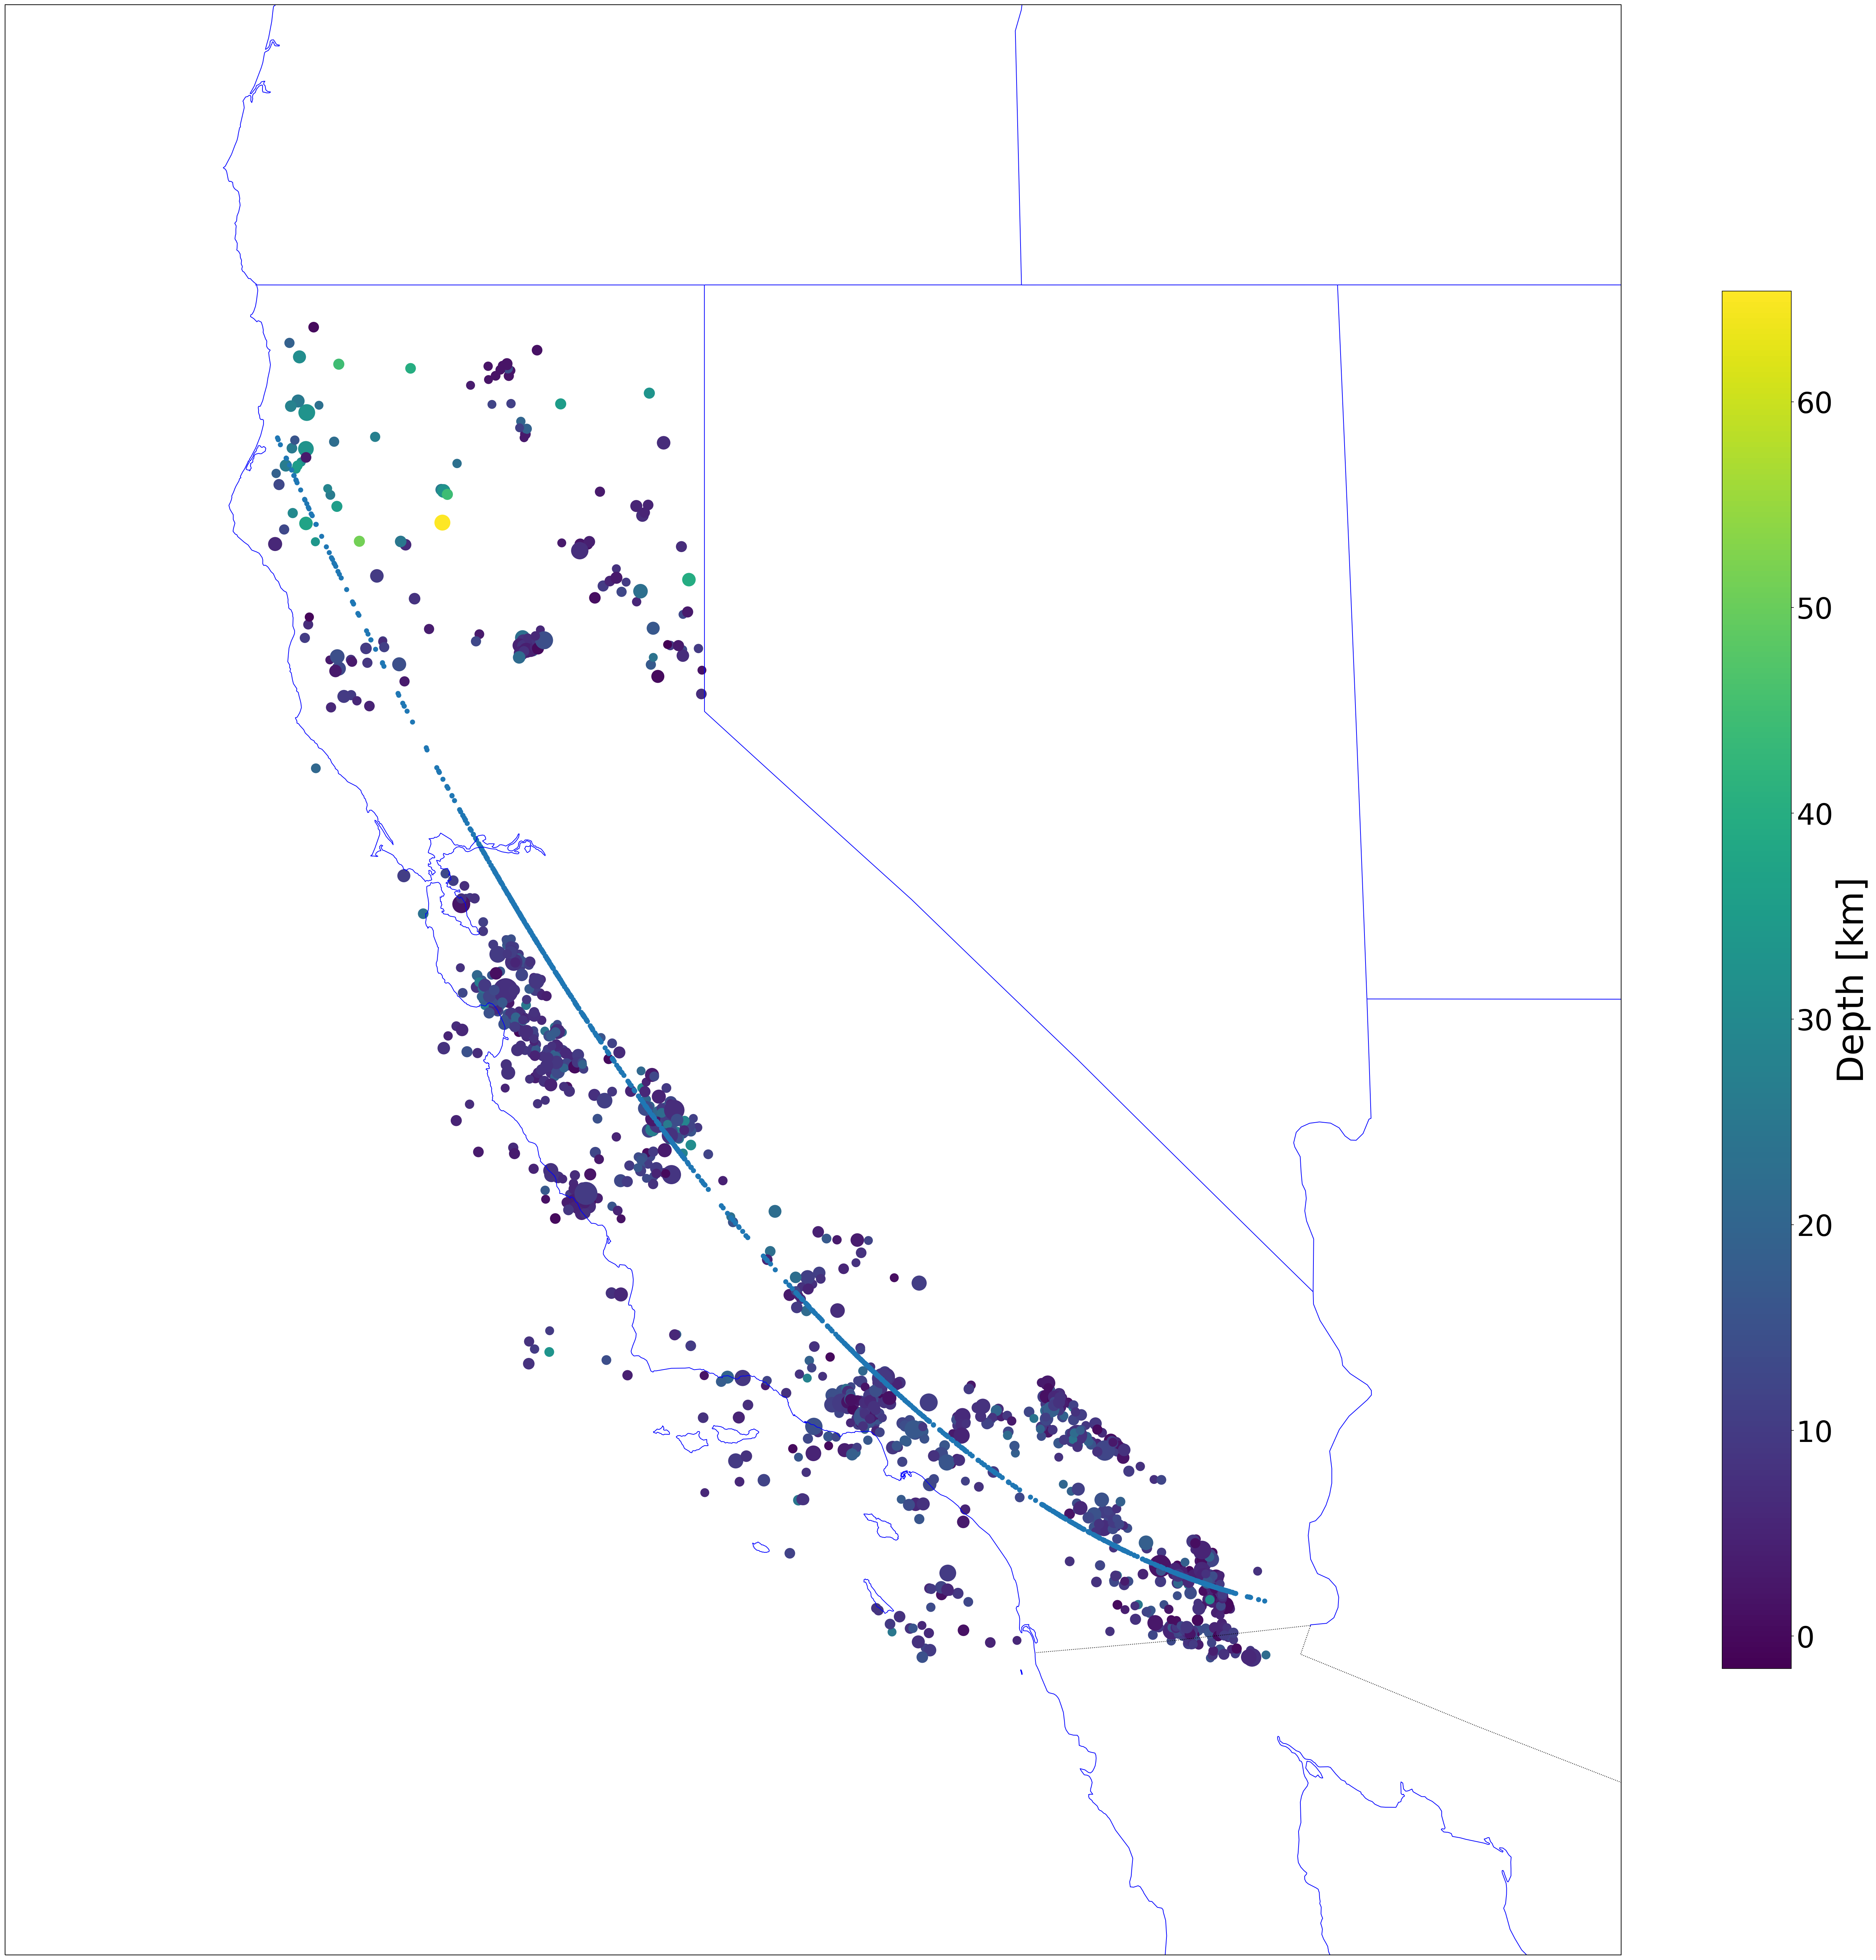

In [189]:
fig = plt.figure(figsize=(50,50))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude = -120))

# Plot all coastal california earthquakes
events = ax.scatter(calon, calat, c=cadep, s=camag, transform=ccrs.PlateCarree())

# center map over california showing whole state
ax.set_extent([ca_w-2, ca_e+2, ca_s-2, ca_n+2], crs=ccrs.Geodetic())

# add state borders, coastlines, and country borders for visualization aid
ax.add_feature(cfeature.BORDERS, linestyle=':')

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='blue')

ax.coastlines(resolution='10m', color='blue')

# add the depth color bar
cbar = plt.colorbar(events, shrink=0.7)
cbar.set_label('Depth [km]', fontsize=50)
cbar.ax.tick_params(labelsize=40)

# plot the found fault line
y = a*np.array(calon)**2 + b*np.array(calon) + c
ax.scatter(calon, y, transform=ccrs.PlateCarree())

print('Earthquakes plus line of best fit inidicating prospective plate boundary.')
plt.show()

In [190]:
## comparison of actual san andreas faulut line and calculated fault line
## Curtosey of http://qingkaikong.blogspot.com/2016/06/using-folium-4-draw-lines-plot-san.html
places_on_SAF = [('Point Delgada', 40.0215325, -124.0691973),
('Point Arena', 38.9088, -123.6931),
('Point Reyes', 38.0440, -122.7984),
('Daly City', 37.6879, -122.4702),
('Bautista', 36.8455, -121.5380),
('Parkfield', 35.8997, -120.4327),
('Cholame', 35.7239, -120.2965),
('Bitter Creek National Wildlife Refuge', 34.9342, -119.4005),
('Frazier Park', 34.8228, -118.9448),
('Palmdale', 34.5794, -118.1165),
('San Bernardino', 34.1083, -117.2898),
('Desert Hot Springs', 33.9611, -116.5017),
('Salton Sea State Recreation Area', 33.5088, -115.9181)]

# get the coordinates for these places
saf_lats = [x[1] for x in places_on_SAF]
saf_lons = [x[2] for x in places_on_SAF]

Comparison of found plate boudary with actual plate boundary.


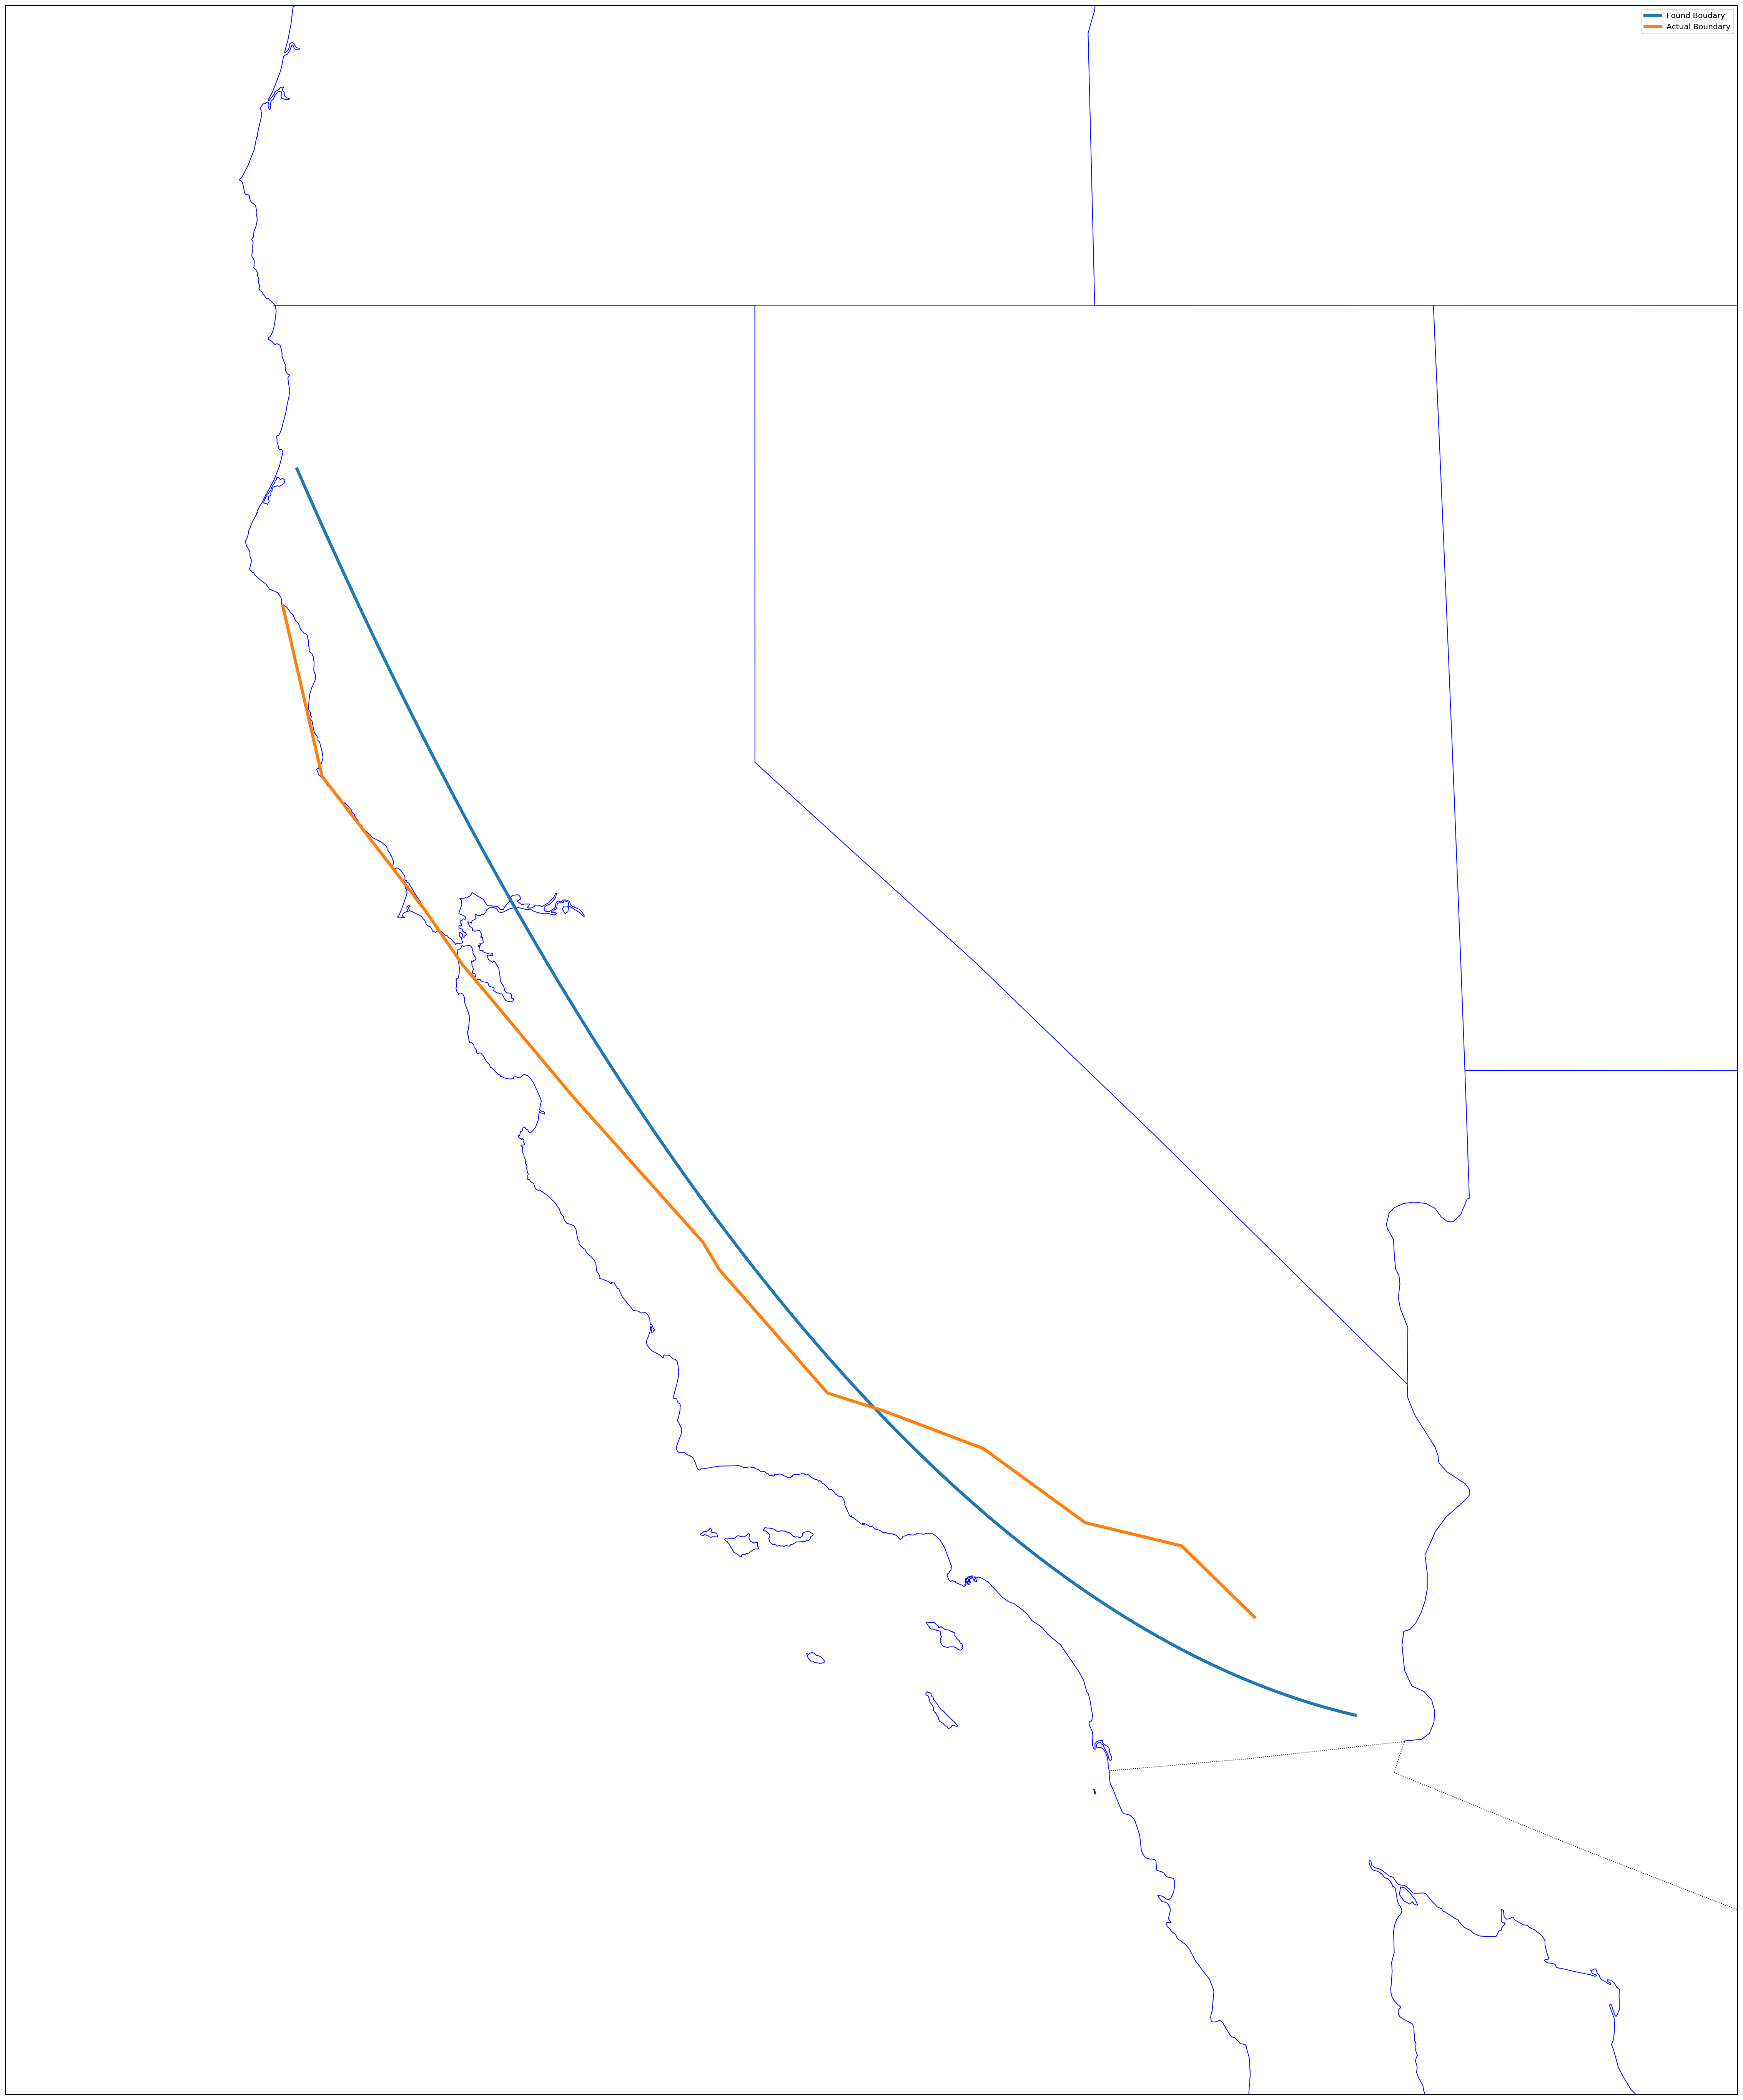

In [273]:
fig = plt.figure(figsize=(50,50))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude = -120))

# center map over california showing whole state
ax.set_extent([ca_w-2, ca_e+2, ca_s-2, ca_n+2], crs=ccrs.Geodetic())

# add state borders, coastlines, and country borders for visualization aid
ax.add_feature(cfeature.BORDERS, linestyle=':')

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='blue')

ax.coastlines(resolution='10m', color='blue')

# plot the found fault line
calon.sort()
y = a*np.array(calon)**2 + b*np.array(calon) + c
ax.plot(calon, y, transform=ccrs.PlateCarree(), label="Found Boudary", linewidth=4)

# plot the actual fault line
ax.plot(saf_lons, saf_lats, transform=ccrs.PlateCarree(), label = "Actual Boundary", linewidth=4)
plt.legend()


print('Comparison of found plate boudary with actual plate boundary.')
plt.show()

## Goal 2: Show over time, the spread of earthquakes on the San Andreas fault (visualization)

In [213]:
## san andreas fault co-ordinates from pt 1
x = calon
y = a*np.array(calon)**2 + b*np.array(calon) + c

In [214]:
## equation solver for x and y
find_y = lambda x: a*x**2 + b*x + c
find_x = lambda y: np.roots([a, b, c-y])

In [259]:
## find distance between two GPS points in meters
## formula from https://www.movable-type.co.uk/scripts/latlong.html
def distance(x1, y1, x2, y2):
    R = 6371e3 # metres
    phi1 = y1 * np.pi/180 # φ, λ in radians
    phi2 = y2 * np.pi/180
    delt_phi = (y1-y2) * np.pi/180
    delt_lambda = (x1-x2) * np.pi/180

    temp_a = np.sin(delt_phi/2) * np.sin(delt_phi/2) + np.cos(phi1) * np.cos(phi2) * np.sin(delt_lambda/2) * np.sin(delt_lambda/2)
    temp_c = 2 * np.arctan2(np.sqrt(temp_a), np.sqrt(1-temp_a))

    return R * temp_c / 1000 #kilometers
    #return np.sqrt((x2-x1)**2 + (y2-y1)**2)

In [260]:
def inv_slope(x1, y1, x2, y2):
    return - (1 / ((y1 - y2) / (x1 - x2)))

In [262]:
fault_eqs = []
for eq in cali_eq:
    org = eq.origins
    ## find distance to point from line
    
    ## find perpendicular line through fault (approximation)
    x1, y1 = org[0].longitude, find_y(org[0].longitude)
    x2 = find_x(org[0].latitude)[0] if (-180 <= find_x(org[0].latitude)[0] <= 180) and not np.iscomplex(np.roots([a, b-slope, c-k])[0]) else find_x(org[0].latitude)[1]
    y2 = org[0].latitude
    slope = inv_slope(x1, y1, x2, y2)
    k = org[0].latitude - slope*org[0].longitude
    
    ## find new point on line
    close_x = np.roots([a, b-slope, c-k])[0] if (-180 <= np.roots([a, b-slope, c-k])[0] <= 180) and not np.iscomplex(np.roots([a, b-slope, c-k])[0]) else np.roots([a, b-slope, c-k])[1]
    if np.iscomplex(close_x):
        continue
    close_y = slope*close_x + k
    if distance(org[0].longitude, org[0].latitude, close_x, close_y) < 10:
        fault_eqs.append(eq)

In [265]:
years = []
by_year = []
for i in range(0,len(fault_eqs)):
    yr = fault_eqs[i].origins[0].time.year
    if yr not in years:
        years.append(yr)
        new_section = [(fault_eqs[i].origins[0].longitude, fault_eqs[i].origins[0].latitude)]
        by_year.append(new_section)
    else:
        by_year[-1].append((fault_eqs[i].origins[0].longitude, fault_eqs[i].origins[0].latitude))

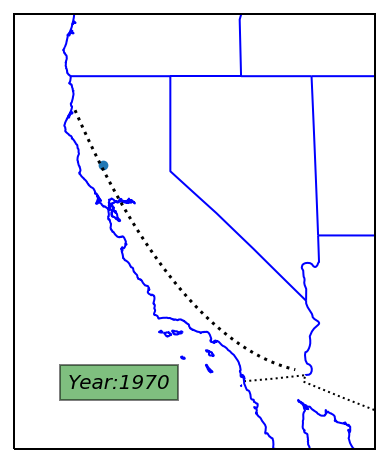

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [290]:
from matplotlib.animation import FFMpegWriter
metadata = dict(title='Earthquakes in California on San Andreas Fault Over Time', artist='Matplotlib',comment='Final Project')
writer = FFMpegWriter(fps=15, metadata=metadata)
fig = plt.figure()
calon.sort()
y = a*np.array(calon)**2 + b*np.array(calon) + c

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude = -120))
ax.plot(calon, y, transform=ccrs.PlateCarree(), color="black", linestyle=":")

years = years[::-1] # reverse to 1970 -> present
by_year = by_year[::-1]

with writer.saving(fig, "final_project.mp4", dpi=200):
    nf = 100
    for yr in range(len(years)):
        lst = np.array(by_year[yr])
#         ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude = -120))
        events = ax.scatter(lst[:,0],  lst[:,1], transform=ccrs.PlateCarree(), s=15)

        # center map over california showing whole state
        ax.set_extent([ca_w-2, ca_e+2, ca_s-2, ca_n+2], crs=ccrs.Geodetic())

        # add state borders, coastlines, and country borders for visualization aid
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        states_provinces = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lines',
                scale='50m',
                facecolor='none')

        ax.add_feature(states_provinces, edgecolor='blue')
        
        ax.text(ca_w, ca_s, 'Year:' + str(years[yr]), style='oblique',verticalalignment='center',
        bbox={'facecolor': 'green', 'alpha': 0.5}, transform=ccrs.Geodetic())

        ax.coastlines(resolution='10m', color='blue')
       
        plt.show()
        plt.draw()
        
        plt.pause(0.05)
        writer.grab_frame()